# Empirical Analysis of Fuzzbench Data
Generates Table 2 and Figures 5-7 in https://mboehme.github.io/paper/CCS21.pdf.

To cite this data or evaluation, please use
```bibtex
@inproceedings{aflchurn,
 author = {Zhu, Xiaogang and B{\"o}hme, Marcel}, 
 title = {Regression Greybox Fuzzing},
 booktitle = {Proceedings of the 28th ACM Conference on Computer and Communications Security},
 series = {CCS},
 year = {2021},
 numpages = {12},
}
```

## Requirements

In [16]:
library(dplyr)
library(stringr)
library(scales)
library(tidyr)
library(scales)
library(ggplot2)


## Load and Inspect Fuzzbench Data

In [17]:
fb = read.csv("fuzzbench.csv",header=TRUE)
print(paste("Avg. time:",mean(fb$total/3600), "hours"))
summary(fb)
levels(factor(fb$subject))

[1] "Avg. time: 19.2020667574644 hours"


                                       subject                  fuzzer    
 unicorn_fuzz_emu_arm_armbe                : 316    aflchurn_pe2   : 463  
 grok_grk_decompress_fuzzer                : 307    aflchurn_texp03: 450  
 picotls_fuzz-asn1                         : 302    aflchurn_texp01: 446  
 neomutt_address-fuzz                      : 300    aflchurn_powadd: 443  
 libxml2_libxml2_xml_reader_for_file_fuzzer: 298    afl            : 442  
 libhtp_fuzz_htp                           : 293    aflchurn_rrank : 442  
 (Other)                                   :3446   (Other)         :2576  
           trial          total             tte          crashes       
  trial-753101:   1   Min.   :  808    Timeout:2068   Min.   :   0.00  
  trial-753102:   1   1st Qu.:75334    5      : 236   1st Qu.:   0.00  
  trial-753103:   1   Median :82776    6      :  38   Median :   4.00  
  trial-753104:   1   Mean   :69127    10     :  15   Mean   :  58.49  
  trial-753105:   1   3rd Qu.:82796    2

[1] "aspell_aspell_fuzzer"                      
 [2] "file_magic_fuzzer"                         
 [3] "grok_grk_decompress_fuzzer"                
 [4] "harfbuzz_hb-shape-fuzzer"                  
 [5] "libgit2_objects_fuzzer"                    
 [6] "libhtp_fuzz_htp"                           
 [7] "libxml2_libxml2_xml_reader_for_file_fuzzer"
 [8] "ndpi_fuzz_process_packet"                  
 [9] "neomutt_address-fuzz"                      
[10] "openssl_x509"                              
[11] "openvswitch_odp_target"                    
[12] "picotls_fuzz-asn1"                         
[13] "systemd_fuzz-varlink"                      
[14] "unbound_fuzz_1_fuzzer"                     
[15] "unicorn_fuzz_emu_arm_armbe"                
[16] "usrsctp_fuzzer_connect"                    
[17] "yara_dotnet_fuzzer"                        
[18] "zstd_stream_decompress"

In [18]:
# Cleanup
fb = subset(fb, ! grepl("aflchurn$",fuzzer)) # Remove old aflchurn
levels(fb$fuzzer)[grepl("aflchurn_texp03",levels(fb$fuzzer))] <- "aflchurn" # Rename new aflchurn

In [19]:
# Fuzzbench aborts some runs. Load only the `TopN` longest-running campaigns
TOPN=20

BASE="afl$"
OURS="aflchurn$"

nonregressions=c("unicorn_fuzz_emu_arm_armbe","muparser_set_eval_fuzzer","ndpi_fuzz_process_packet",
                 "harfbuzz_hb-shape-fuzzer","ndpi_fuzz_ndpi_reader","htslib_hts_open_fuzzer")

quickly_crashing=c("jsoncpp_jsoncpp_fuzzer","libcbor_cbor_load_fuzzer","libsass_data_context_fuzzer")

topn_fb = fb %>% 
  arrange(desc(total)) %>% 
  group_by(subject,fuzzer) %>% 
  slice(1:TOPN)

topn_fb$tte = as.numeric(as.character(as.factor(topn_fb$tte)))

# Remove subjects that are *never* crashing
temp = topn_fb %>% 
  group_by(subject,fuzzer) %>% 
  summarise(crashing_trials = length(crashes[crashes > 0])) %>% 
  group_by(subject) %>% 
  summarise(crashing_trials=mean(crashing_trials))
never_crashing = subset(temp, crashing_trials == 0.0)$subject
print(paste("Removing subjects that are never crashing: ",never_crashing))
topn_fb = subset(topn_fb, ! subject %in% never_crashing)


min_total = min(topn_fb$total)
max_total = max(topn_fb$total)
print(paste("Avg. time:",mean(topn_fb$total/3600), "hours"))
print(paste("Max. time:",max_total/3600, "hours"))
print(paste("Min. time:",min_total/3600, "hours"))
temp=topn_fb %>% arrange((total)) %>% group_by(subject,fuzzer) %>% slice(1:1)
print(paste("Avg. min. time: ", mean(temp$total)/3600, "hours"))

if (nrow(subset(topn_fb %>% group_by(subject,fuzzer) %>% summarise(trials = length(trial)), trials < TOPN)) > 0) {
  printf("ERROR: Less than TOPN trials")
}

# Show the number of data points for each fuzzer in terms of #subjects.
topn_fb %>% 
        group_by(subject,fuzzer) %>% summarise(yo=mean(tte)) %>% 
        group_by(fuzzer) %>% summarise(subjects=length(subject))

# Show the number of data points for each subject in terms of #fuzzers.
topn_fb %>% 
        group_by(subject,fuzzer) %>% summarise(yo=mean(tte)) %>% 
        group_by(subject) %>% summarise(fuzzers=length(fuzzer))

summary(topn_fb)

`summarise()` has grouped output by 'subject'. You can override using the `.groups` argument.



[1] "Removing subjects that are never crashing:  neomutt_address-fuzz"  
[2] "Removing subjects that are never crashing:  openvswitch_odp_target"
[3] "Removing subjects that are never crashing:  picotls_fuzz-asn1"     
[1] "Avg. time: 21.9320692760943 hours"
[1] "Max. time: 23 hours"
[1] "Min. time: 5.87527777777778 hours"
[1] "Avg. min. time:  20.4823468013468 hours"


`summarise()` has grouped output by 'subject'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'subject'. You can override using the `.groups` argument.



fuzzer,subjects
<fct>,<int>
afl,15
aflchurn_noaco,15
aflchurn_noage,15
aflchurn_nochurn,15
aflchurn_pe2,15
aflchurn_powadd,15
aflchurn_rrank,15
aflchurn_texp01,15
aflchurn,15


`summarise()` has grouped output by 'subject'. You can override using the `.groups` argument.



subject,fuzzers
<fct>,<int>
aspell_aspell_fuzzer,11
file_magic_fuzzer,11
grok_grk_decompress_fuzzer,11
harfbuzz_hb-shape-fuzzer,11
libgit2_objects_fuzzer,11
libhtp_fuzz_htp,11
libxml2_libxml2_xml_reader_for_file_fuzzer,11
ndpi_fuzz_process_packet,11
openssl_x509,11


                       subject                   fuzzer    
 aspell_aspell_fuzzer      : 220    afl             : 300  
 file_magic_fuzzer         : 220    aflchurn_noaco  : 300  
 grok_grk_decompress_fuzzer: 220    aflchurn_noage  : 300  
 harfbuzz_hb-shape-fuzzer  : 220    aflchurn_nochurn: 300  
 libgit2_objects_fuzzer    : 220    aflchurn_pe2    : 300  
 libhtp_fuzz_htp           : 220    aflchurn_powadd : 300  
 (Other)                   :1980   (Other)          :1500  
           trial          total            tte             crashes       
  trial-753103:   1   Min.   :21151   Min.   :    5.0   Min.   :   0.00  
  trial-753105:   1   1st Qu.:82733   1st Qu.:  337.8   1st Qu.:   1.00  
  trial-753106:   1   Median :82790   Median : 1957.5   Median :   6.00  
  trial-753107:   1   Mean   :78955   Mean   : 9525.8   Mean   :  74.99  
  trial-753109:   1   3rd Qu.:82797   3rd Qu.:11427.0   3rd Qu.:  48.00  
  trial-753110:   1   Max.   :82800   Max.   :82688.0   Max.   :1064.00  
 (

# Table 2. Effectiveness of Regression Greybox Fuzzing
## Time To Error

In [20]:
base_fb = subset(topn_fb, grepl(BASE,fuzzer))
names(base_fb)[names(base_fb) == "subject"] <- "Subject"

options(warn=-1)
tte_results = topn_fb %>% 
  group_by(subject,fuzzer) %>% 
  summarise(base_tte = mean(subset(base_fb, subject == Subject)$tte, na.rm=TRUE)/3600,
            ours_tte = mean(tte, na.rm=TRUE)/3600,
            total = mean(total)/3600
           )


head(subset(tte_results, grepl(BASE,fuzzer)),n=5)
subset(tte_results, grepl(OURS,fuzzer)& ! subject %in% nonregressions)

`summarise()` has grouped output by 'subject'. You can override using the `.groups` argument.



subject,fuzzer,base_tte,ours_tte,total
<fct>,<fct>,<dbl>,<dbl>,<dbl>
aspell_aspell_fuzzer,afl,2.048597222,2.048597222,22.96194
file_magic_fuzzer,afl,0.088805556,0.088805556,22.82243
grok_grk_decompress_fuzzer,afl,1.624660494,1.624660494,22.94039
harfbuzz_hb-shape-fuzzer,afl,7.276047009,7.276047009,22.80629
libgit2_objects_fuzzer,afl,0.004347222,0.004347222,22.96175


subject,fuzzer,base_tte,ours_tte,total
<fct>,<fct>,<dbl>,<dbl>,<dbl>
aspell_aspell_fuzzer,aflchurn,2.048597222,1.7392917,22.90650
file_magic_fuzzer,aflchurn,0.088805556,0.1685972,22.95933
grok_grk_decompress_fuzzer,aflchurn,1.624660494,1.6103509,20.08312
libgit2_objects_fuzzer,aflchurn,0.004347222,0.0023750,22.78729
libhtp_fuzz_htp,aflchurn,3.626069444,2.0145278,22.63286
libxml2_libxml2_xml_reader_for_file_fuzzer,aflchurn,0.713458333,0.7278333,22.77535
openssl_x509,aflchurn,5.487291667,3.0191250,22.85511
systemd_fuzz-varlink,aflchurn,NaN,21.2930556,22.79844
unbound_fuzz_1_fuzzer,aflchurn,10.374967320,6.2466975,22.78679


Turn time to error into a readable string.

In [21]:
to_time_string = function(x) {
  hrs = as.integer(floor(x))
  min = sprintf("%02d",as.integer(round((x - hrs)*60),0))
  hrs = sprintf("%02d",hrs)
  return(paste(hrs,"h ",min,"m",sep=""))
}
    
results = tte_results %>%
  arrange(base_tte) %>% 
  mutate(
      base_TimeToError=to_time_string(base_tte),
      ours_TimeToError=to_time_string(ours_tte),
      factor_TimeToError=round(ours_tte/base_tte,1))
results = results[c(1,2,6:8)]
#head(results)
subset(results,grepl(OURS,fuzzer)& ! subject %in% nonregressions)

subject,fuzzer,base_TimeToError,ours_TimeToError,factor_TimeToError
<fct>,<fct>,<chr>,<chr>,<dbl>
libgit2_objects_fuzzer,aflchurn,00h 00m,00h 00m,0.5
file_magic_fuzzer,aflchurn,00h 05m,00h 10m,1.9
yara_dotnet_fuzzer,aflchurn,00h 10m,00h 13m,1.3
libxml2_libxml2_xml_reader_for_file_fuzzer,aflchurn,00h 43m,00h 44m,1.0
grok_grk_decompress_fuzzer,aflchurn,01h 37m,01h 37m,1.0
aspell_aspell_fuzzer,aflchurn,02h 03m,01h 44m,0.8
libhtp_fuzz_htp,aflchurn,03h 38m,02h 01m,0.6
openssl_x509,aflchurn,05h 29m,03h 01m,0.6
unbound_fuzz_1_fuzzer,aflchurn,10h 22m,06h 15m,0.6


## Crashing Trials

In [22]:
base_fb = subset(topn_fb, grepl(BASE,fuzzer))
names(base_fb)[names(base_fb) == "subject"] <- "Subject"

options(warn=-1)
trials_results = topn_fb %>% 
  group_by(subject,fuzzer) %>% 
  summarise(
      base_crashing_trials = length(subset(base_fb, subject == Subject & crashes > 0)$crashes),
      ours_crashing_trials = length(crashes[crashes > 0]),
      factor_crashing_trials = round(ours_crashing_trials/base_crashing_trials,1))

results = results %>% left_join(trials_results)
#results

`summarise()` has grouped output by 'subject'. You can override using the `.groups` argument.

Joining, by = c("subject", "fuzzer")



In [23]:
temp = trials_results %>% 
  group_by(subject) %>% summarise(ours_crashing_trials=mean(ours_crashing_trials))

always_crashing = subset(temp, ours_crashing_trials == TOPN)$subject
paste("Removing subjects that are always crashing:",always_crashing)
trials_results = subset(trials_results, ! subject %in% always_crashing)

avg_trials_results = trials_results %>% #subset(trials_results, ! subject %in% nonregressions) %>% 
  group_by(fuzzer) %>% 
  summarise(
    ours_crashing_trials =mean(ours_crashing_trials),
    base_crashing_trials = mean(base_crashing_trials))

avg_trials_results$factor = avg_trials_results$ours_crashing_trials / avg_trials_results$base_crashing_trials
avg_trials_results

[1] "Removing subjects that are always crashing: file_magic_fuzzer"                         
[2] "Removing subjects that are always crashing: libgit2_objects_fuzzer"                    
[3] "Removing subjects that are always crashing: libxml2_libxml2_xml_reader_for_file_fuzzer"
[4] "Removing subjects that are always crashing: ndpi_fuzz_process_packet"                  
[5] "Removing subjects that are always crashing: yara_dotnet_fuzzer"

fuzzer,ours_crashing_trials,base_crashing_trials,factor
<fct>,<dbl>,<dbl>,<dbl>
afl,13.0,13,1.0000000
aflchurn_noaco,12.6,13,0.9692308
aflchurn_noage,12.6,13,0.9692308
aflchurn_nochurn,13.4,13,1.0307692
aflchurn_pe2,13.2,13,1.0153846
aflchurn_powadd,12.1,13,0.9307692
aflchurn_rrank,12.6,13,0.9692308
aflchurn_texp01,12.9,13,0.9923077
aflchurn,13.6,13,1.0461538


## Unique Crashes

In [24]:
base_fb = subset(topn_fb, grepl(BASE,fuzzer))
names(base_fb)[names(base_fb) == "subject"] <- "Subject"

options(warn=-1)
crash_results = topn_fb %>% 
  group_by(subject,fuzzer) %>% 
  summarise(base_crashes = mean(subset(base_fb, subject == Subject)$crashes),
            ours_crashes = mean(crashes),
            factor = round(ours_crashes / base_crashes,1)
           )


subset(crash_results, grepl(OURS,fuzzer) & ! subject %in% nonregressions)
#subset(crash_results, grepl("aflchurn_aco",fuzzer) | grepl("aflchurn$",fuzzer))
results = results %>% left_join(crash_results[c(1:2,3:5)])

`summarise()` has grouped output by 'subject'. You can override using the `.groups` argument.



subject,fuzzer,base_crashes,ours_crashes,factor
<fct>,<fct>,<dbl>,<dbl>,<dbl>
aspell_aspell_fuzzer,aflchurn,7.60,7.65,1.0
file_magic_fuzzer,aflchurn,4.70,5.25,1.1
grok_grk_decompress_fuzzer,aflchurn,9.85,4.20,0.4
libgit2_objects_fuzzer,aflchurn,48.05,71.50,1.5
libhtp_fuzz_htp,aflchurn,55.95,156.50,2.8
libxml2_libxml2_xml_reader_for_file_fuzzer,aflchurn,777.95,704.20,0.9
openssl_x509,aflchurn,8.70,6.60,0.8
systemd_fuzz-varlink,aflchurn,0.00,0.05,Inf
unbound_fuzz_1_fuzzer,aflchurn,5.90,9.25,1.6


Joining, by = c("subject", "fuzzer")



In [25]:
temp = trials_results %>% 
  group_by(subject) %>% summarise(ours_crashing_trials=mean(ours_crashing_trials))

always_crashing = subset(temp, ours_crashing_trials == TOPN)$subject
paste("Removing subjects that are always crashing:",always_crashing)
trials_results = subset(trials_results, ! subject %in% always_crashing)

avg_trials_results = trials_results %>% #subset(trials_results, ! subject %in% nonregressions) %>% 
  group_by(fuzzer) %>% 
  summarise(
    ours_crashing_trials =mean(ours_crashing_trials),
    base_crashing_trials = mean(base_crashing_trials))

avg_trials_results$factor = avg_trials_results$ours_crashing_trials / avg_trials_results$base_crashing_trials
avg_trials_results

[1] "Removing subjects that are always crashing: "

fuzzer,ours_crashing_trials,base_crashing_trials,factor
<fct>,<dbl>,<dbl>,<dbl>
afl,13.0,13,1.0000000
aflchurn_noaco,12.6,13,0.9692308
aflchurn_noage,12.6,13,0.9692308
aflchurn_nochurn,13.4,13,1.0307692
aflchurn_pe2,13.2,13,1.0153846
aflchurn_powadd,12.1,13,0.9307692
aflchurn_rrank,12.6,13,0.9692308
aflchurn_texp01,12.9,13,0.9923077
aflchurn,13.6,13,1.0461538


In [26]:
## Summarize all results

## Generate Table 2

In [27]:
results2 = subset(results,grepl(OURS,fuzzer) & ! subject %in% nonregressions)[-2] 
results2
print(paste("tte_factor (mean, median):", mean(results2$factor_TimeToError,na.rm=T), median(results2$factor_TimeToError,na.rm=T)))
print(paste("crashing_trials_factor (mean, median):", 
            mean(subset(results2,base_crashing_trials<TOPN & base_crashing_trials>0)$factor_crashing_trials), 
            median(subset(results2,base_crashing_trials<TOPN)$factor_crashing_trials)))


subject,base_TimeToError,ours_TimeToError,factor_TimeToError,base_crashing_trials,ours_crashing_trials,factor_crashing_trials,base_crashes,ours_crashes,factor
<fct>,<chr>,<chr>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
libgit2_objects_fuzzer,00h 00m,00h 00m,0.5,20,20,1.0,48.05,71.50,1.5
file_magic_fuzzer,00h 05m,00h 10m,1.9,20,20,1.0,4.70,5.25,1.1
yara_dotnet_fuzzer,00h 10m,00h 13m,1.3,20,20,1.0,25.70,20.45,0.8
libxml2_libxml2_xml_reader_for_file_fuzzer,00h 43m,00h 44m,1.0,20,20,1.0,777.95,704.20,0.9
grok_grk_decompress_fuzzer,01h 37m,01h 37m,1.0,18,19,1.1,9.85,4.20,0.4
aspell_aspell_fuzzer,02h 03m,01h 44m,0.8,20,20,1.0,7.60,7.65,1.0
libhtp_fuzz_htp,03h 38m,02h 01m,0.6,20,20,1.0,55.95,156.50,2.8
openssl_x509,05h 29m,03h 01m,0.6,20,20,1.0,8.70,6.60,0.8
unbound_fuzz_1_fuzzer,10h 22m,06h 15m,0.6,17,18,1.1,5.90,9.25,1.6


[1] "tte_factor (mean, median): 0.89 0.7"
[1] "crashing_trials_factor (mean, median): 1.4 2"


To generate Latex code for the table uncomment this:

In [28]:
#install.packages("Hmisc")
#require(Hmisc)
#latex(results2,file="")

# Figures 5 to 7. Deduplication Results
## Load Requirements

In [30]:
install.packages("hash")
library(hash)


The downloaded binary packages are in
	/var/folders/gh/s8q13hss51vd6vmtfyh0vwl5y352w4/T//Rtmp75ffAD/downloaded_packages


hash-2.2.6.1 provided by Decision Patterns




## Load and Inspect Data

In [31]:
ttb = read.csv("deduplicated.csv",header=TRUE)
# Make sure the trial is in the TOPN!
ttb = subset(ttb, trial %in% topn_fb$trial)
ttb$crash_time = as.numeric(as.character(ttb$crash_time))
# Choose only our subjects
ttb = subset(ttb, grepl("aspell", benchmark) |
                  grepl("libhtp", benchmark) |
                  grepl("openssl", benchmark) |
                  grepl("grok", benchmark) |
                  grepl("unbound", benchmark) |
                  grepl("zstd", benchmark) |
                  grepl("systemd", benchmark) |
                  grepl("usrsctp", benchmark) |
                  grepl("libgit2", benchmark) |
                  grepl("file_magic", benchmark) |
                  grepl("yara", benchmark) |
                  grepl("libxml2", benchmark))

ttb$short_name = sapply(ttb$benchmark, function(x) return(str_trim(unlist(str_split(x,'_'))[1])))
ttb$fuzzer = sapply(ttb$fuzzer, function(x) return(as.factor(str_trim(x))))

ttb = subset(ttb, ! grepl("^aflchurn$",fuzzer)) # Remove old aflchurn
levels(ttb$fuzzer)[grepl("aflchurn_texp03",levels(ttb$fuzzer))] <- "aflchurn" # Rename new aflchurn
ttb = arrange(ttb,desc(fuzzer))
                    
# Remove duplicates
duplicates = c("5fee371c","6b179f65","64ef5289",
               "778525a6","e3beb3bd","11fab8a2")#,"0d811709")#)#libhtp
                             
ttb = subset(ttb, ! str_trim(as.character(stack_hash)) %in% duplicates)

ossfuzz_map <- hash()
ossfuzz_map[["7e1523e7"]] = "11194" #regression #libgit2
ossfuzz_map[["b2902450"]] = "11007" #regression #libgit2
ossfuzz_map[["01534ca1"]] = "11382*" #regression #libgit2
ossfuzz_map[["a499164a"]] = "13222*" #regression #file
ossfuzz_map[["a7033cb9"]] = "17187" #regression #aspell
ossfuzz_map[["77dd8a8a"]] = "17722" #regression #openssl
ossfuzz_map[["fcbefa74"]] = "17715*" #regression #openssl
ossfuzz_map[["7ec60ffc"]] = "14708*" #regression #systemd
ossfuzz_map[["1016e474"]] = "20308*" #regression #unbound
ossfuzz_map[["1819adfb"]] = "20308*" #regression #unbound
ossfuzz_map[["a956baf7"]] = "20308*" #regression #unbound
ossfuzz_map[["5a3b1fe8"]] = "14368*" #regression #zstd
ossfuzz_map[["cbb16e60"]] = "14368*" #regression #zstd
ossfuzz_map[["0d811709"]] = "17198*" #regression #libhtp (?)
#ossfuzz_map[["11fab8a2"]] = "17198*" #regression #libhtp (?)
#ossfuzz_map[["778525a6"]] = "17198*" #regression #libhtp (?)
#ossfuzz_map[["e3beb3bd"]] = "17198*" #regression #libhtp (?)
ossfuzz_map[["139ca4c0"]] = "24427"#"28313" #regression #grok (?)
ossfuzz_map[["6f8550cb"]] = "28227" #regression #grok (?)
ossfuzz_map[["c16ff9af"]] = "24427" #regression #grok (?)
ossfuzz_map[["9ae0ab26"]] = "27428" #regression #grok
ossfuzz_map[["b8abecb6"]] = "27386*" #regression #grok
ossfuzz_map[["da219090"]] = "27386*" #regression #grok
ossfuzz_map[["23e1b548"]] = "11945" #regression #yara
ossfuzz_map[["ece0878b"]] = "19591*" #regression #yara
#ossfuzz_map[["5fee371c"]] = "*19591*" #regression #yara
#ossfuzz_map[["64ef5289"]] = "*19591*" #regression #yara
ossfuzz_map[["f48a0494"]] = "17737*" #regression #libxml2
ossfuzz_map[["e23f5180"]] = "UaF" #regression #libxml2
ossfuzz_map[["8ffa7154"]] = "UaF" #regression #libxml2
ossfuzz_map[["54b5e0bb"]] = "UaF" #regression #libxml2
ossfuzz_map[["56fa8708"]] = "UaF" #regression #libxml2
ossfuzz_map[["283fecc9"]] = "UaF" #regression #libxml2
ossfuzz_map[["9784f757"]] = "UaF" #regression #libxml2
ossfuzz_map[["121f5f5b"]] = "dblfree" #regression #libxml2
ossfuzz_map[["ba03dd62"]] = "dblfree" #regression #libxml2

ttb$ossfuzz = sapply(ttb$stack_hash, function(x) { 
  stack_id = str_trim(as.character(x))
  if (stack_id %in% keys(ossfuzz_map)) {
    return(ossfuzz_map[[stack_id]])
  }
  return(stack_id)
})

ttb$bug_id = sapply(ttb$ossfuzz, function(x) {
  name = head(subset(ttb, ossfuzz == x)$short_name,n=1)
  return(paste(name,"_",x,sep=""))
})
             

## Generate Figures 5 and 6
* Figure 5. Deduplication results (AFL versus AFLChurn). Effectiveness of Regression Greybox Fuzzing
* Figure 6. Deduplication Results (NoAge and NoChurn). Individual effectiveness of the two heuristics: NoAge is a variant of AFLChurn that is guided only by how frequently the executed code has been changed. NoChurn is a variant that is guided only by how recently the executed code has been changed.

Saving 12.6 x 4.9 in image

Saving 12.6 x 4.9 in image



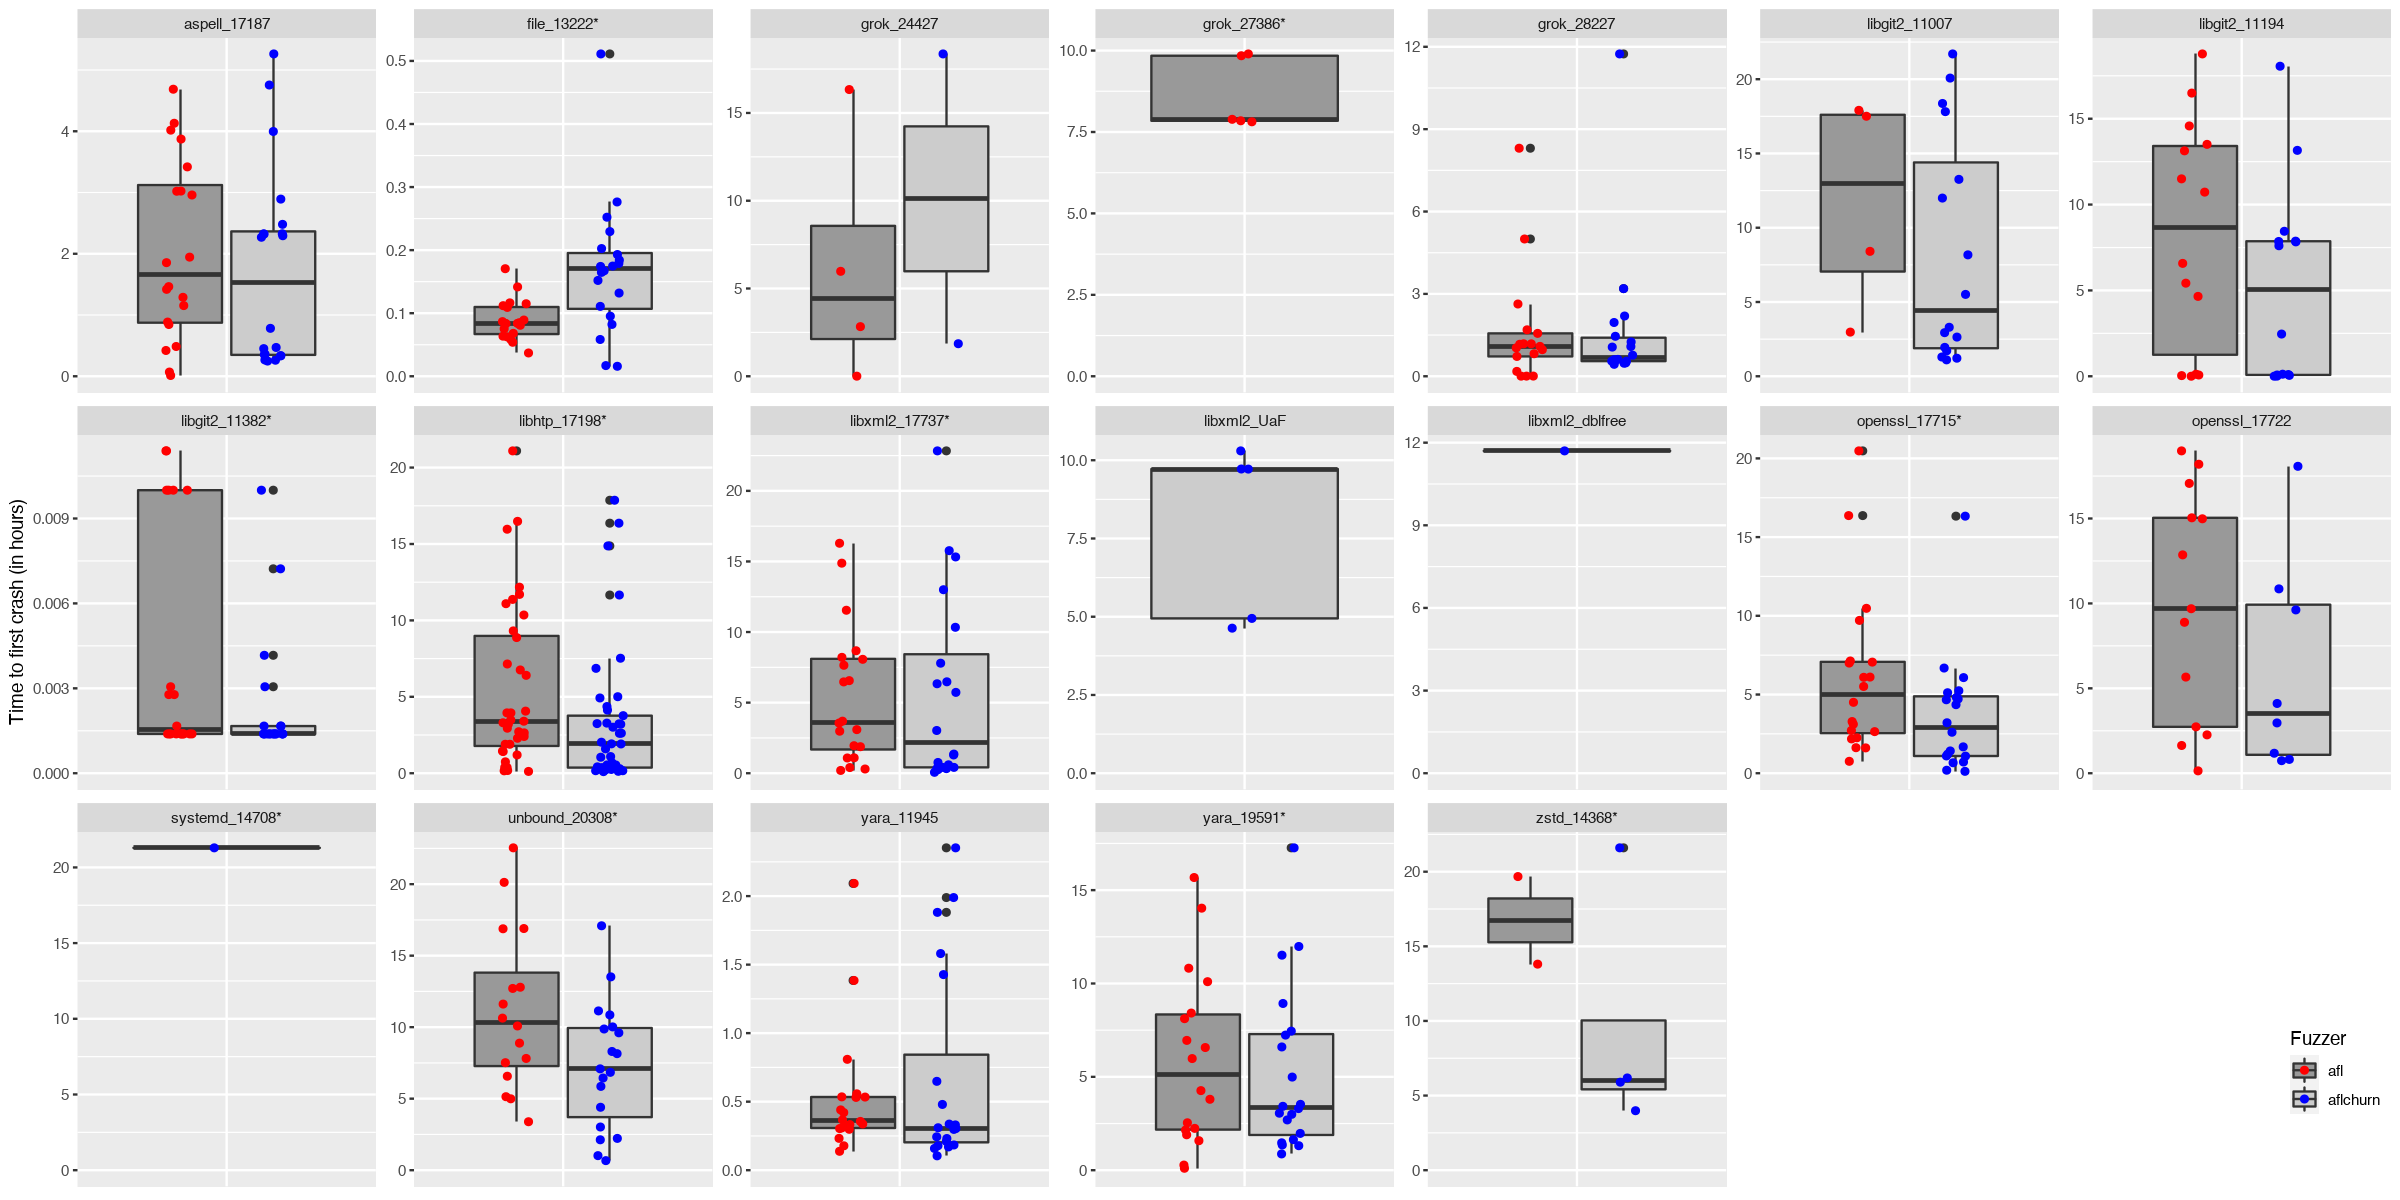

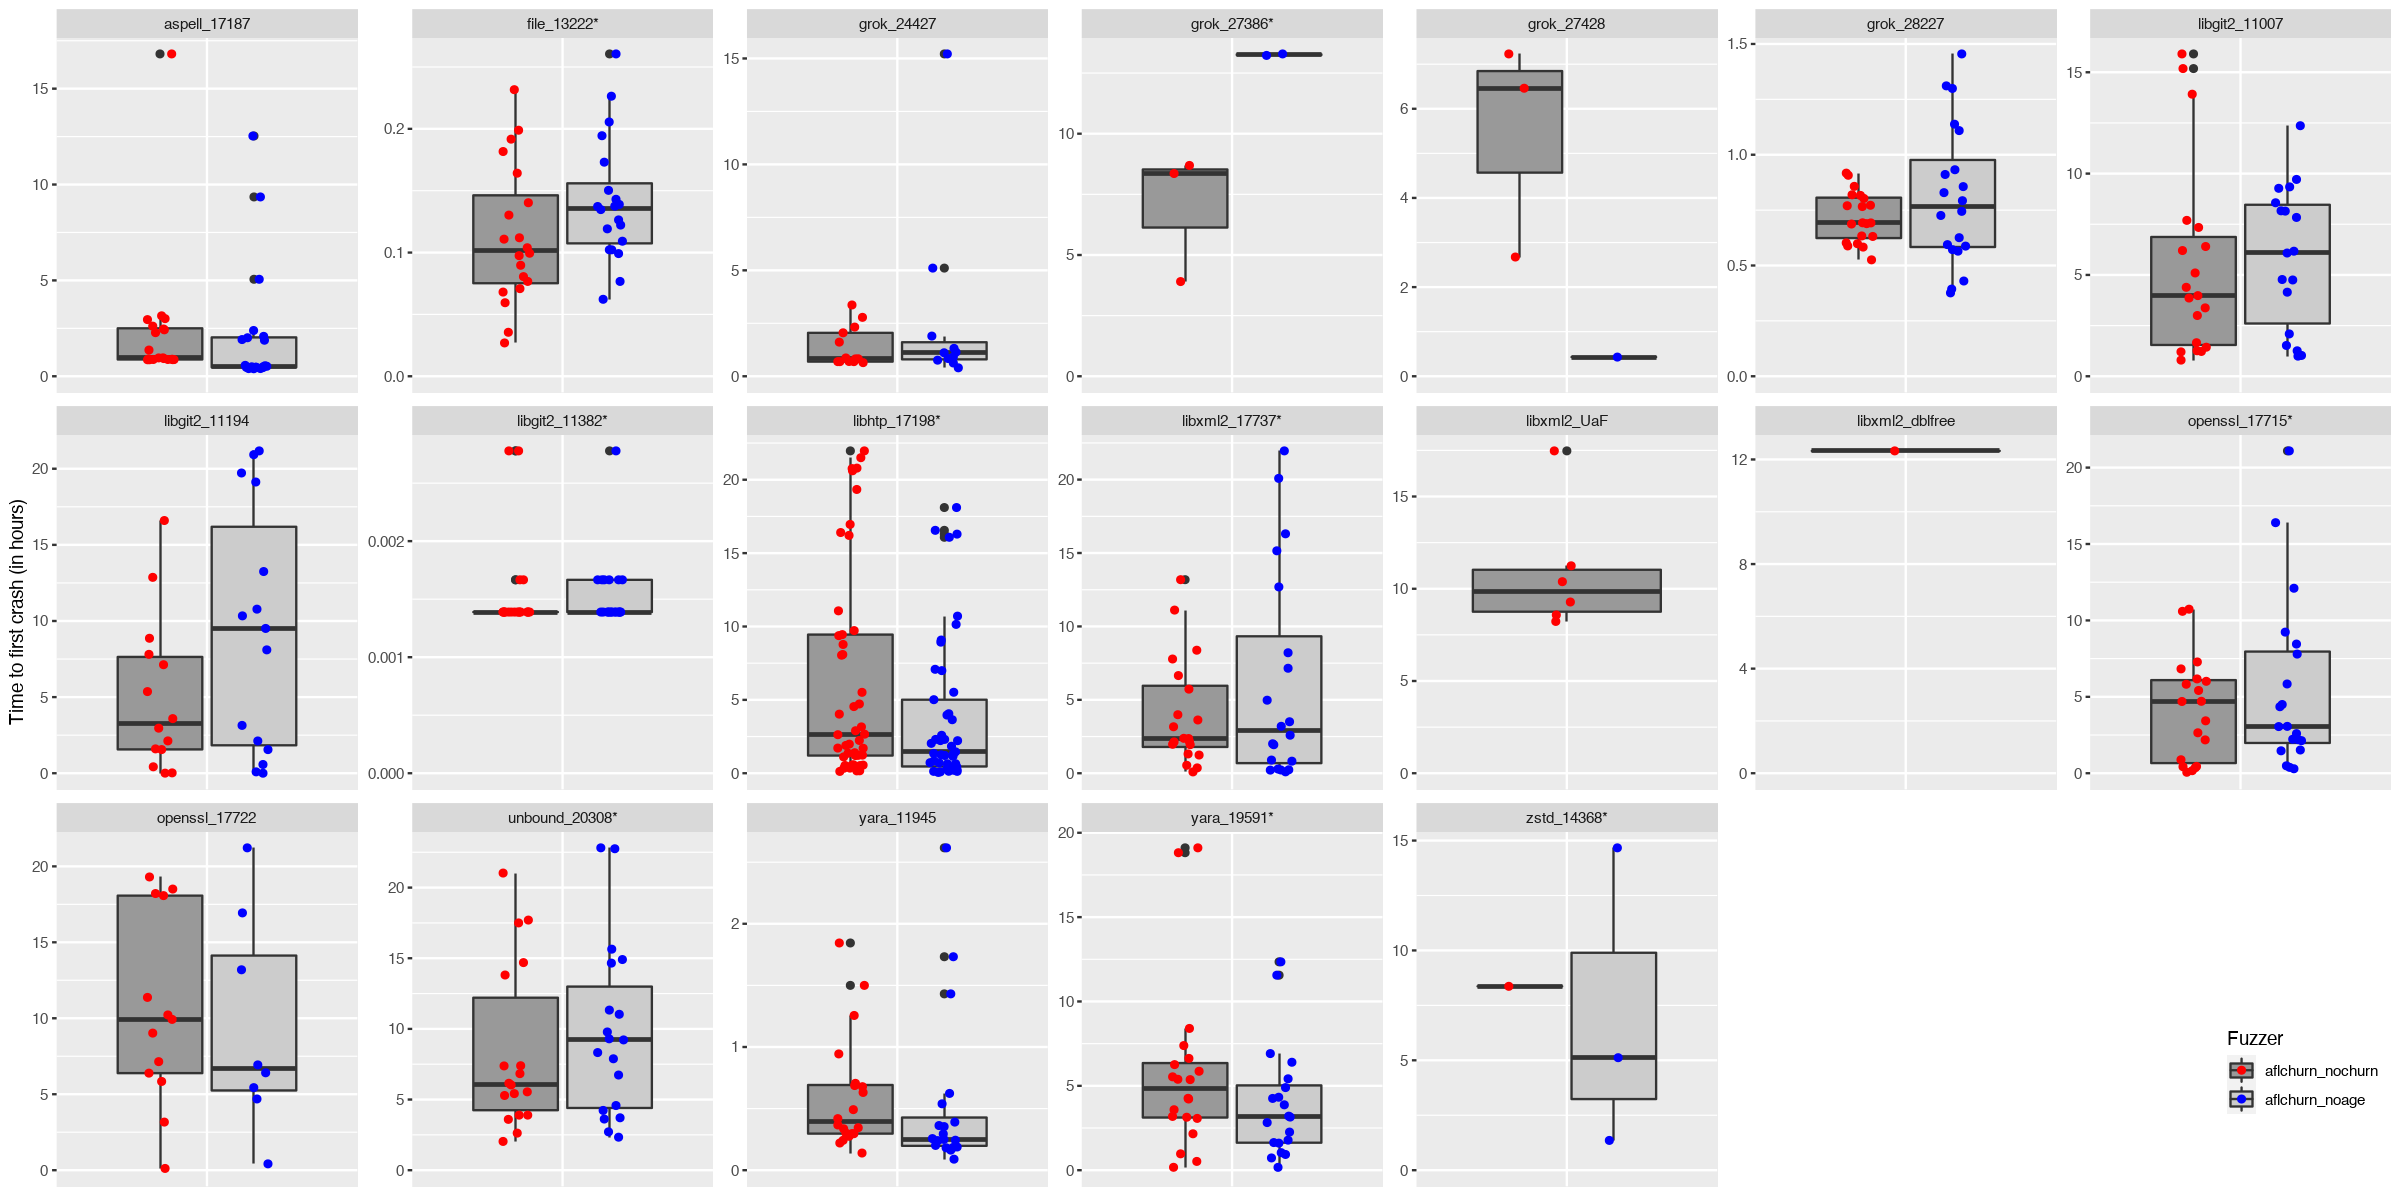

In [32]:
compare_perbug = function(fuzzer1, fuzzer2, filename) {
  ttb2 = subset(ttb, grepl(paste("^",fuzzer1,"$",sep=""),fuzzer) | grepl(paste("^",fuzzer2,"$",sep=""),fuzzer))

  p = ggplot(ttb2, aes(bug_id, crash_time/3600,fill=reorder(fuzzer,desc(fuzzer)))) +
  geom_boxplot() +
  geom_point(aes(color=reorder(fuzzer,desc(fuzzer))), position=position_jitterdodge()) +
  xlab("")+
  ylab("Time to first crash (in hours)") +
  scale_colour_manual(values = c("red", "blue"), name="Fuzzer") +
  scale_fill_grey(name="Fuzzer",start=0.6,end=0.8) +
  facet_wrap(~bug_id, scale="free",ncol=7) +
  expand_limits(y = 0)
  p = p + theme(legend.position = c(1, 0.1), legend.justification = "right")
  p = p + theme(axis.title.x=element_blank(), axis.text.x=element_blank(), axis.ticks.x=element_blank())
  print(p)
    
  ggsave(filename,scale=0.7,width=18)
}
compare_perbug("afl","aflchurn","Figure.5.pdf")
compare_perbug("aflchurn_noage","aflchurn_nochurn","Figure.6.pdf")

# Figure 7. Intersection Plot
## Load Requirements

In [35]:
install.packages("UpSetR")
install.packages("ggplotify")
library(UpSetR)
library(grid)
library(gridExtra)
library(ggplotify)


The downloaded binary packages are in
	/var/folders/gh/s8q13hss51vd6vmtfyh0vwl5y352w4/T//Rtmp75ffAD/downloaded_packages


also installing the dependencies 'BiocManager', 'gridGraphics', 'rvcheck'





  There are binary versions available but the source versions are later:
              binary  source needs_compilation
BiocManager  1.30.10 1.30.15             FALSE
gridGraphics   0.5-0   0.5-1             FALSE
ggplotify      0.0.5   0.0.7             FALSE


The downloaded binary packages are in
	/var/folders/gh/s8q13hss51vd6vmtfyh0vwl5y352w4/T//Rtmp75ffAD/downloaded_packages


installing the source packages 'BiocManager', 'gridGraphics', 'ggplotify'




## Generate Figure 7
* Figure 7. Intersecting Sets (UpsetR). Number of bugs found jointly by different sets of fuzzers. Not showing empty intersections. The two bugs in second position are the additional UaF and double-free bugs in LibXML2.

pdf 
  2

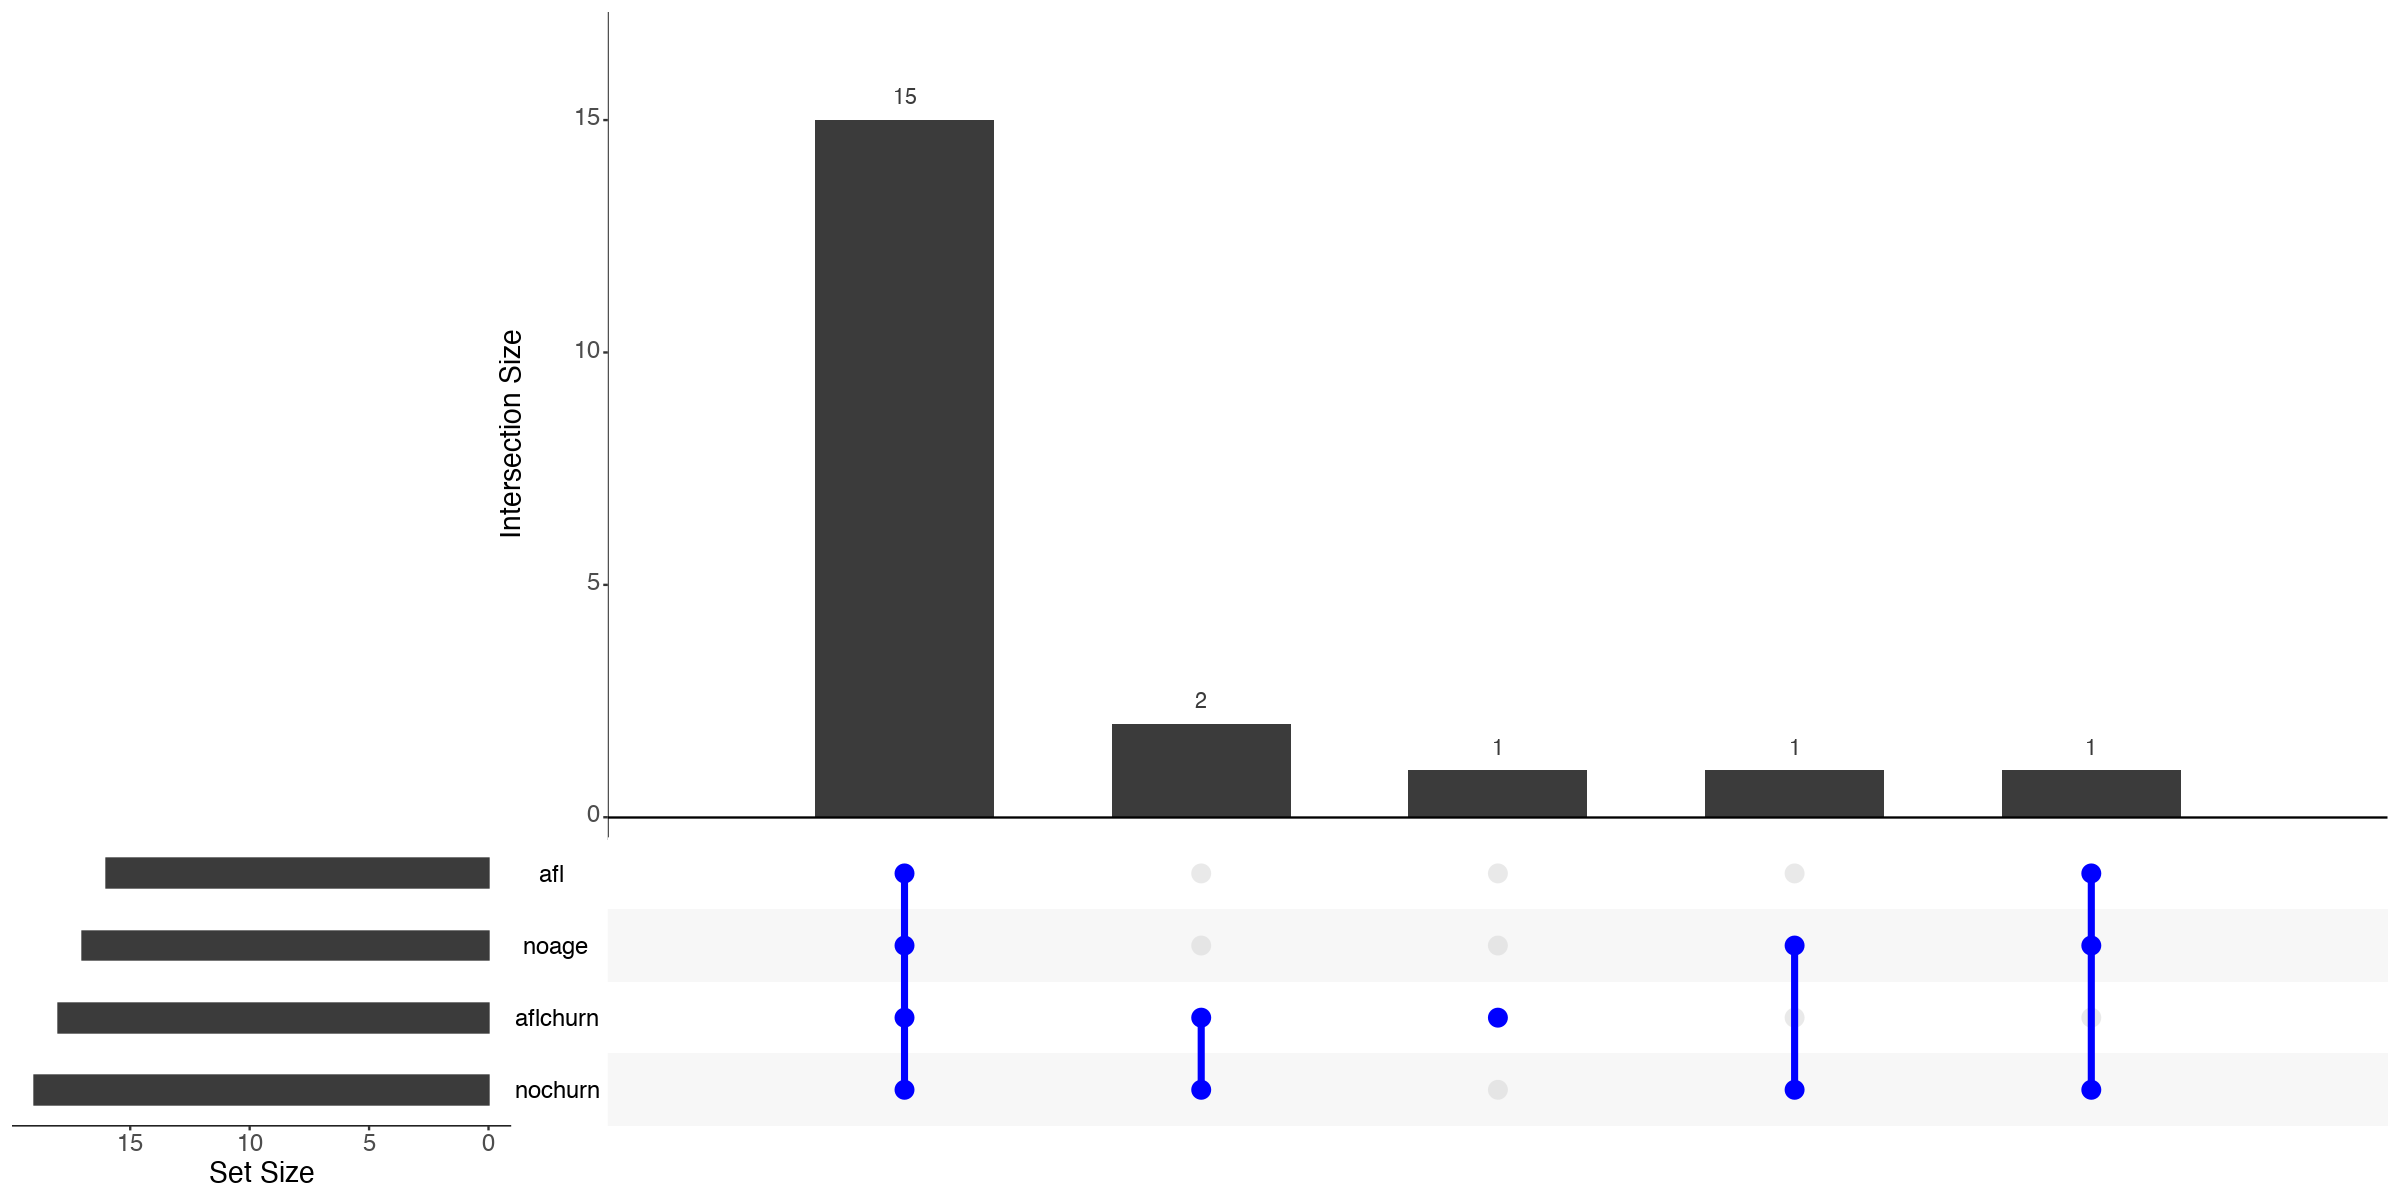

In [36]:
pdf(file="Figure.7.pdf",width=12,height=5) # or other device
                        
ttb2 = ttb %>% group_by(fuzzer,bug_id) %>% tally()
p = upset(fromList(list(afl=subset(ttb2,grepl("afl$",fuzzer))$bug_id, 
                 aflchurn=subset(ttb2,grepl("aflchurn$",fuzzer))$bug_id, 
                 noage=subset(ttb2,grepl("aflchurn_noage",fuzzer))$bug_id, 
                 nochurn=subset(ttb2,grepl("aflchurn_nochurn",fuzzer))$bug_id)),
    order.by = "freq",
    text.scale=2, matrix.color="blue",#empty.intersections=TRUE,
    point.size = 5, #mainbar.y.label = unlist(str_split(.x,'_'))[1],
    line.size = 1.5)
p
dev.off()
p